In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [3]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=25

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [11]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch)


(32, 256, 256, 3)
tf.Tensor([2 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0 1 1 1 0 0 2 0 0 0 0 1 0 1 1 0 1], shape=(32,), dtype=int32)


hi


Text(0.5, 1.0, 'Potato___healthy')

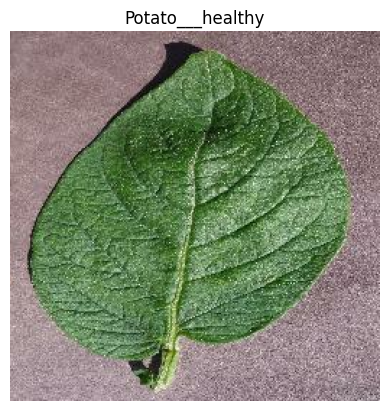

In [14]:
plt.imshow(image_batch[0].numpy().astype("uint8"))
plt.axis("off")
plt.title(class_names[label_batch[0]])

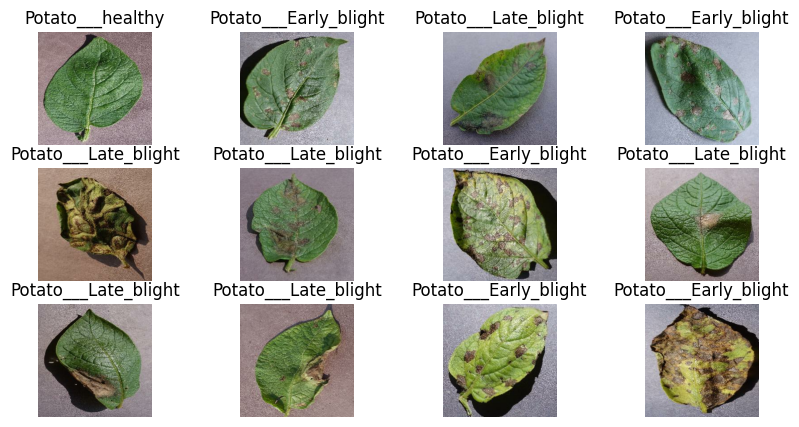

In [19]:
plt.figure(figsize=(10,5))
for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

68

In [10]:
train_ds=dataset.take(54)

In [11]:
test_ds=dataset.skip(54)
val_ds=dataset.take(7)
test_ds=dataset.skip(7)

In [12]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)

    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds


In [13]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [14]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

data preprocessing


In [15]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [17]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [18]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model=models.Sequential([
     resize_and_rescale,
     data_augmentation,
     layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
     layers.MaxPooling2D((2,2)),
     layers.Conv2D(64,(3,3),activation='relu'),
     layers.MaxPooling2D((2,2)),
     layers.Conv2D(64,(3,3),activation='relu'),
     layers.MaxPooling2D((2,2)),
     layers.Conv2D(64,(3,3),activation='relu'),
     layers.MaxPooling2D((2,2)),
     layers.Flatten(),
     layers.Dense(64,activation='relu'),
     layers.Dense(n_classes,activation='softmax'),

])
model.build(input_shape=input_shape)

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds

)

Epoch 1/25
54/54 [==============================] - 42s 699ms/step - loss: 0.7985 - accuracy: 0.5961 - val_loss: 0.5190 - val_accuracy: 0.8229
Epoch 2/25
54/54 [==============================] - 39s 715ms/step - loss: 0.4668 - accuracy: 0.8385 - val_loss: 0.3669 - val_accuracy: 0.8646
Epoch 3/25
54/54 [==============================] - 36s 671ms/step - loss: 0.3807 - accuracy: 0.8542 - val_loss: 0.2910 - val_accuracy: 0.8698
Epoch 4/25
54/54 [==============================] - 35s 643ms/step - loss: 0.2912 - accuracy: 0.8912 - val_loss: 0.3405 - val_accuracy: 0.8646
Epoch 5/25
54/54 [==============================] - 37s 685ms/step - loss: 0.1299 - accuracy: 0.9583 - val_loss: 0.6173 - val_accuracy: 0.8021
Epoch 6/25
54/54 [==============================] - 45s 843ms/step - loss: 0.1491 - accuracy: 0.9404 - val_loss: 0.1157 - val_accuracy: 0.9583
Epoch 7/25
54/54 [==============================] - 74s 1s/step - loss: 0.1220 - accuracy: 0.9491 - val_loss: 0.7719 - val_accuracy: 0.7604
Ep

In [20]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 4s 308ms/step - loss: 0.2522 - accuracy: 0.9397


In [21]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 54}

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
acc = history.history['accuracy']
val_acc= history.history['val_accuracy']

loss= history.history['loss']
val_loss= history.history['val_loss']

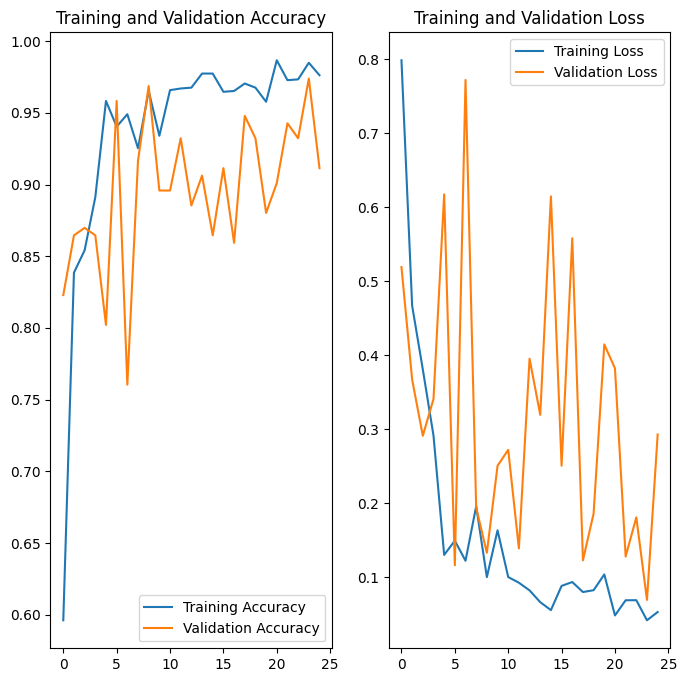

In [24]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label:  Potato___Early_blight
1/1 [==============================] - 0s 492ms/step
predicted label: Potato___Early_blight
first image to predict
actual label:  Potato___Late_blight
1/1 [==============================] - 1s 505ms/step
predicted label: Potato___Late_blight


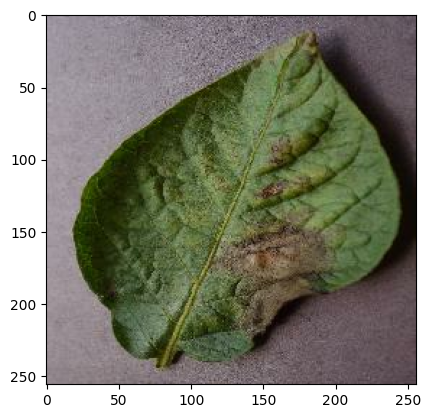

In [31]:
for images_batch,labels_batch in test_ds.take(2):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)

    print("actual label: ",class_names[first_label])
    batch_prediction=model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])



In [26]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) # create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 26ms/step


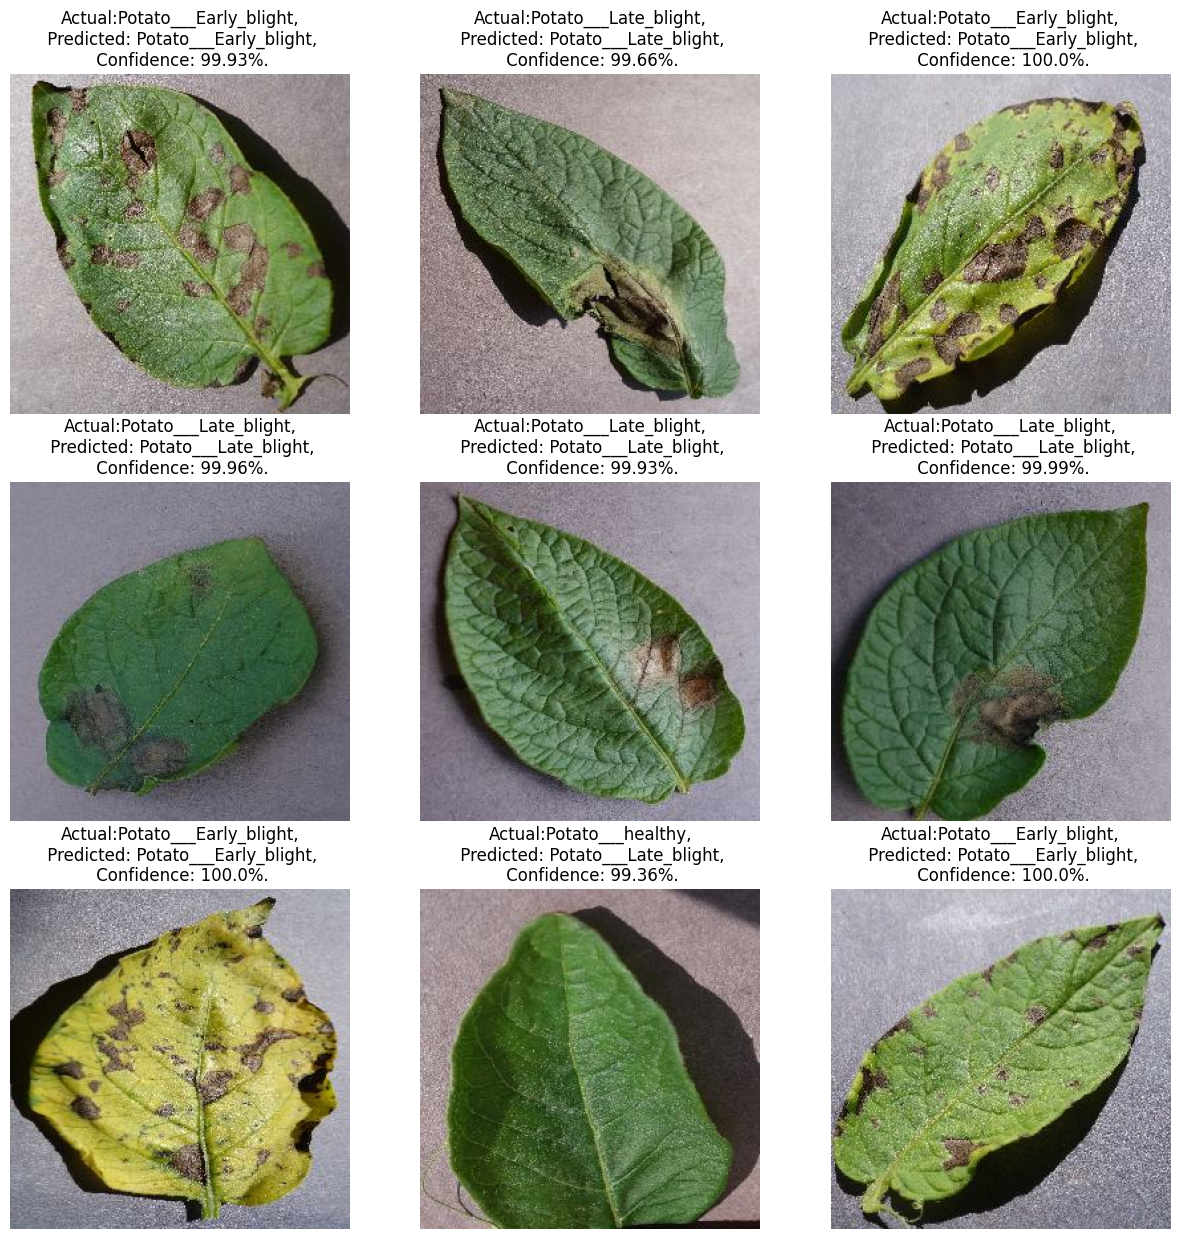

In [27]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class,confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%.")


        plt.axis("off")

In [28]:
# import os
# model_version=max([int(i) for i in os.listdir("models")+[0]])+1
# model.save(f"models/{model_version}")